# Where Should We Build Brooklyn's Newest Donut Shop?

A data scientist has been tasked with determining the best Brooklyn neighborhood to build Delicious Donuts. This notebook contains the analysis that will feed into the final report.

In [1]:
#importing necessary libraries
import requests 
import pandas as pd 
import numpy as np 
import random 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
from sklearn.cluster import KMeans
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
!conda install -c conda-forge folium=0.5.0 --yes
import folium 

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Sol

**Pulling in New York Geo Data to Map out Brooklyn**

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


**Restricting the Data to Brooklyn Neighborhoods**

In [8]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


**Map of Brooklyn & Its Neighborhoods**

In [9]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Manhattan using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

**Pulling in Foursquare API Data for Venue Information**

In [10]:
CLIENT_ID = 'WBY2ZRNCHMKWYQBR5YE1JIF3XMZSDBDUCEBDTZSD4BU5BYS5' 
CLIENT_SECRET = '3SZ2NRRZFPPEVBTEIPD2FRGTAV5NZL25EIP2RP4CY00FNB4B' 
VERSION = '20180605' 
LIMIT = 100
radius = 500

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**List of Brooklyn Neighborhoods**

In [13]:
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


**Venues by Brooklyn Neighborhood**

In [16]:
brooklyn_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,The Bookmark Shoppe,40.624577,-74.030562,Bookstore


In [17]:
brooklyn_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,47,47,47,47,47,47
Bay Ridge,87,87,87,87,87,87
Bedford Stuyvesant,25,25,25,25,25,25
Bensonhurst,33,33,33,33,33,33
Bergen Beach,6,6,6,6,6,6
...,...,...,...,...,...,...
Vinegar Hill,28,28,28,28,28,28
Weeksville,15,15,15,15,15,15
Williamsburg,34,34,34,34,34,34


In [16]:
print('There are {} unique categories.'.format(len(brooklyn_venues['Venue Category'].unique())))

There are 280 unique categories.


In [18]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

brooklyn_onehot.head()

,Yoga Studio,Accessories Store,American Restaurant,Animal Shelter,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped

,Neighborhood,Yoga Studio,Accessories Store,American Restaurant,Animal Shelter,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Bath Beach,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.021277,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,Bay Ridge,0.011494,0.0,0.034483,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.011494,0.0,0.011494,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,Bedford Stuyvesant,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.040000,0.040000,0.0,0.0
3,Bensonhurst,0.000000,0.0,0.030303,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,Bergen Beach,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Vinegar Hill,0.000000,0.0,0.035714,0.0,0.035714,0.0,0.0,0.035714,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.035714,0.035714,0.035714,0.0,0.0
66,Weeksville,0.000000,0.0,0.066667,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
67,Williamsburg,0.029412,0.0,0.000000,0.0,0.000000,0.0,0.0,0.029412,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.029412,0.000000,0.0,0.0
68,Windsor Terrace,0.000000,0.0,0.035714,0.0,0.035714,0.0,0.0,0.000000,0.035714,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.035714,0.0,0.0


**Finding the Most Common Venue in Each Neighborhood**

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Chinese Restaurant,Pharmacy,Fast Food Restaurant,Bubble Tea Shop,Gas Station,Sushi Restaurant,Italian Restaurant,Cantonese Restaurant,Park,Liquor Store
1,Bay Ridge,Spa,Italian Restaurant,Pizza Place,Greek Restaurant,American Restaurant,Bar,Pharmacy,Ice Cream Shop,Playground,Mediterranean Restaurant
2,Bedford Stuyvesant,Bar,Coffee Shop,Café,Pizza Place,Boutique,New American Restaurant,Gift Shop,Gourmet Shop,Juice Bar,Cocktail Bar
3,Bensonhurst,Ice Cream Shop,Donut Shop,Chinese Restaurant,Grocery Store,Sushi Restaurant,Italian Restaurant,Flower Shop,Furniture / Home Store,Liquor Store,Spa
4,Bergen Beach,Harbor / Marina,Donut Shop,Baseball Field,Playground,Athletics & Sports,Women's Store,Factory,Falafel Restaurant,Farm,Farmers Market


**Clustering Neighborhoods Using K-Means**

In [22]:
# set number of clusters
kclusters = 4

brooklyn_grouped_clustering = brooklyn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brooklyn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

brooklyn_merged = brooklyn_data

# merge brooklyn_grouped with brooklyn_data to add latitude/longitude for each neighborhood
brooklyn_merged = brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

brooklyn_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,1,Spa,Italian Restaurant,Pizza Place,Greek Restaurant,American Restaurant,Bar,Pharmacy,Ice Cream Shop,Playground,Mediterranean Restaurant
1,Brooklyn,Bensonhurst,40.611009,-73.995180,1,Ice Cream Shop,Donut Shop,Chinese Restaurant,Grocery Store,Sushi Restaurant,Italian Restaurant,Flower Shop,Furniture / Home Store,Liquor Store,Spa
2,Brooklyn,Sunset Park,40.645103,-74.010316,1,Latin American Restaurant,Bakery,Bank,Pizza Place,Mexican Restaurant,Gym,Pharmacy,Fried Chicken Joint,Mobile Phone Shop,Sandwich Place
3,Brooklyn,Greenpoint,40.730201,-73.954241,1,Bar,Pizza Place,Coffee Shop,Cocktail Bar,Yoga Studio,Tea Room,Deli / Bodega,New American Restaurant,Thrift / Vintage Store,Sushi Restaurant
4,Brooklyn,Gravesend,40.595260,-73.973471,1,Chinese Restaurant,Pizza Place,Lounge,Bakery,Spa,Men's Store,Furniture / Home Store,Martial Arts Dojo,Bar,Music Venue


**Mapping the Clusters**

In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 0

In [25]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Flatbush,Mexican Restaurant,Coffee Shop,Caribbean Restaurant,Juice Bar,Bank,Bakery,Plaza,Deli / Bodega,Donut Shop,Chinese Restaurant
10,East Flatbush,Department Store,Hardware Store,Moving Target,Supermarket,Fast Food Restaurant,Caribbean Restaurant,Chinese Restaurant,Park,Food & Drink Shop,Wine Shop
25,Cypress Hills,Fried Chicken Joint,Ice Cream Shop,Latin American Restaurant,Donut Shop,Fast Food Restaurant,Seafood Restaurant,Pizza Place,Metro Station,Liquor Store,Intersection
26,East New York,Deli / Bodega,Spanish Restaurant,Gym,Plaza,Metro Station,Fried Chicken Joint,Fast Food Restaurant,Event Service,Caribbean Restaurant,Salon / Barbershop
27,Starrett City,Pharmacy,Moving Target,Donut Shop,Convenience Store,Cosmetics Shop,Caribbean Restaurant,Pizza Place,American Restaurant,Flower Shop,Fish Market
28,Canarsie,Caribbean Restaurant,Deli / Bodega,Food,Grocery Store,Gym,Chinese Restaurant,Thai Restaurant,Asian Restaurant,Falafel Restaurant,Event Service
29,Flatlands,Pharmacy,Fried Chicken Joint,Fast Food Restaurant,Caribbean Restaurant,Deli / Bodega,Park,Nightclub,Lounge,Electronics Store,Gym
32,Coney Island,Caribbean Restaurant,Baseball Stadium,Brewery,Athletics & Sports,Pizza Place,Skating Rink,Monument / Landmark,Music Venue,Beach,Theme Park Ride / Attraction
43,Ocean Hill,Deli / Bodega,Playground,Chinese Restaurant,Southern / Soul Food Restaurant,Fried Chicken Joint,Ice Cream Shop,Bakery,Pharmacy,Convenience Store,Coffee Shop
44,City Line,Donut Shop,Grocery Store,Shoe Store,Latin American Restaurant,Pharmacy,Bus Line,Bus Stop,Sandwich Place,Chinese Restaurant,Coffee Shop


Cluster 1

In [26]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bay Ridge,Spa,Italian Restaurant,Pizza Place,Greek Restaurant,American Restaurant,Bar,Pharmacy,Ice Cream Shop,Playground,Mediterranean Restaurant
1,Bensonhurst,Ice Cream Shop,Donut Shop,Chinese Restaurant,Grocery Store,Sushi Restaurant,Italian Restaurant,Flower Shop,Furniture / Home Store,Liquor Store,Spa
2,Sunset Park,Latin American Restaurant,Bakery,Bank,Pizza Place,Mexican Restaurant,Gym,Pharmacy,Fried Chicken Joint,Mobile Phone Shop,Sandwich Place
3,Greenpoint,Bar,Pizza Place,Coffee Shop,Cocktail Bar,Yoga Studio,Tea Room,Deli / Bodega,New American Restaurant,Thrift / Vintage Store,Sushi Restaurant
4,Gravesend,Chinese Restaurant,Pizza Place,Lounge,Bakery,Spa,Men's Store,Furniture / Home Store,Martial Arts Dojo,Bar,Music Venue
5,Brighton Beach,Russian Restaurant,Eastern European Restaurant,Beach,Restaurant,Gourmet Shop,Sushi Restaurant,Mobile Phone Shop,Bank,Bookstore,Fried Chicken Joint
6,Sheepshead Bay,Dessert Shop,Turkish Restaurant,Sandwich Place,Italian Restaurant,Russian Restaurant,Chinese Restaurant,Restaurant,Café,Karaoke Bar,Outlet Store
7,Manhattan Terrace,Pizza Place,Donut Shop,Grocery Store,Cosmetics Shop,Ice Cream Shop,Restaurant,Bagel Shop,Burger Joint,Mobile Phone Shop,Steakhouse
9,Crown Heights,Pizza Place,Café,Museum,Burger Joint,Convenience Store,Candy Store,Supermarket,Bank,Bakery,Bagel Shop
11,Kensington,Grocery Store,Thai Restaurant,Ice Cream Shop,Mexican Restaurant,Pizza Place,Department Store,Burger Joint,Café,Sandwich Place,Restaurant


Cluster 2

In [27]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Mill Island,Pool,Locksmith,Food Truck,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


Cluster 3

In [28]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 3, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,Sea Gate,Spa,Bus Station,IT Services,Beach,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


**Summing Up Venues By Neighborhood**

In [29]:
venue_tot = brooklyn_onehot.groupby('Neighborhood').sum().reset_index()
venue_tot['All Venues'] = venue_tot.sum(axis=1)
venue_tot.head()

,Neighborhood,Yoga Studio,Accessories Store,American Restaurant,Animal Shelter,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,All Venues
0,Bath Beach,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,47
1,Bay Ridge,1,0,3,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,87
2,Bedford Stuyvesant,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,25
3,Bensonhurst,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,33
4,Bergen Beach,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [37]:
most = brooklyn_merged['1st Most Common Venue'].value_counts()
clust0 = brooklyn_merged[brooklyn_merged['Cluster Labels'] == 0]
clust1 = brooklyn_merged[brooklyn_merged['Cluster Labels'] == 1]
clust2 = brooklyn_merged[brooklyn_merged['Cluster Labels'] == 2]
clust3 = brooklyn_merged[brooklyn_merged['Cluster Labels'] == 3]
clust0_most = clust0['1st Most Common Venue'].value_counts()
clust1_most = clust1['1st Most Common Venue'].value_counts()
clust2_most = clust2['1st Most Common Venue'].value_counts()
clust3_most = clust3['1st Most Common Venue'].value_counts()

**Which Venues are the 1st Most Common?**

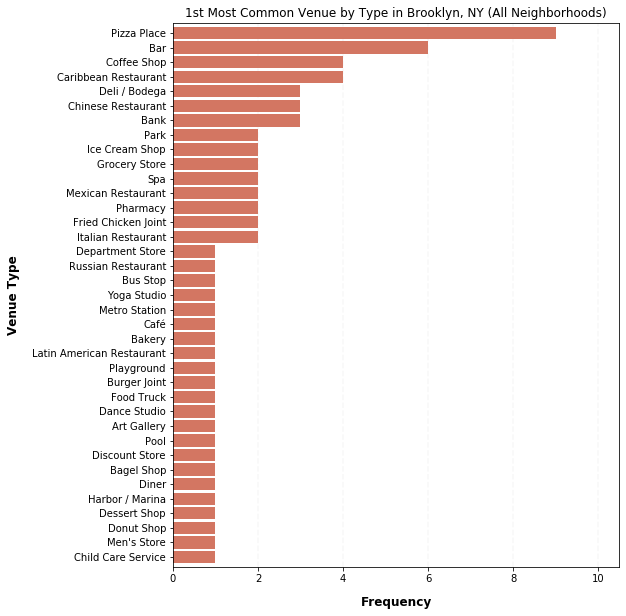

In [35]:
ax = most.plot(kind='barh', figsize=(8, 10), color='#d37662', zorder=2, width=0.85)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title("1st Most Common Venue by Type in Brooklyn, NY (All Neighborhoods)")
# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  # Set x-axis label
    ax.set_xlabel("Frequency", labelpad=12, weight='bold', size=12)

  # Set y-axis label
    ax.set_ylabel("Venue Type", labelpad=12, weight='bold', size=12)

Text(0.5, 1.0, '1st Most Common Venue by Type in Brooklyn, NY Cluster 0')

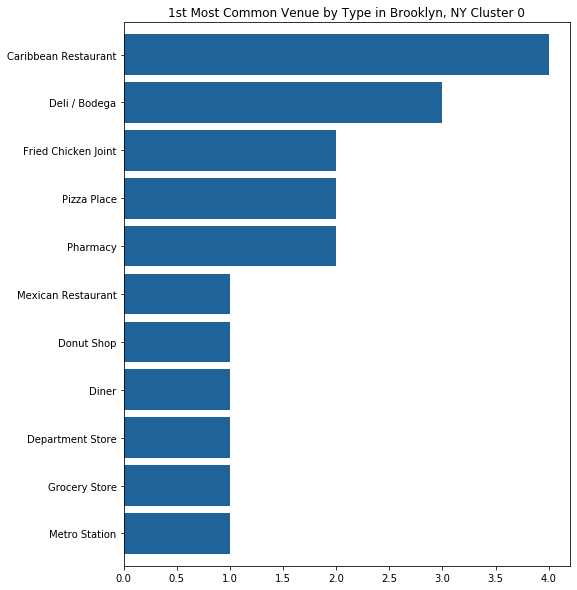

In [40]:
ax0 = clust0_most.plot(kind='barh', figsize=(8, 10), color='#20639b', zorder=2, width=0.85)
ax0.invert_yaxis()  # labels read top-to-bottom
ax0.set_title("1st Most Common Venue by Type in Brooklyn, NY Cluster 0")

Text(0.5, 1.0, '1st Most Common Venue by Type in Brooklyn, NY Cluster 1')

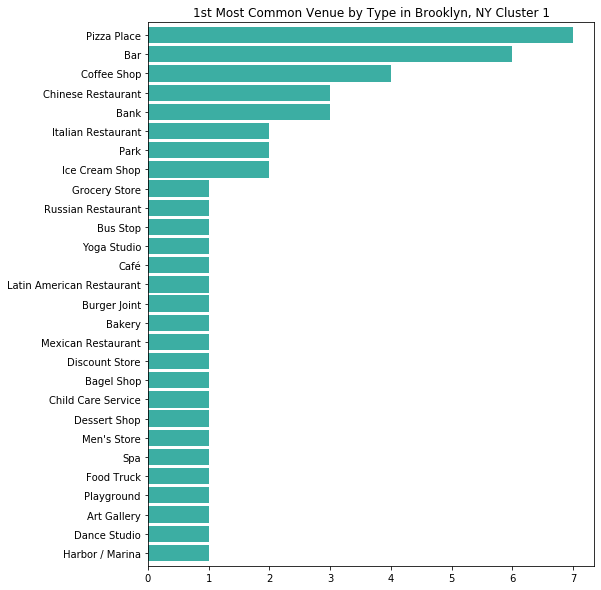

In [41]:
ax1 = clust1_most.plot(kind='barh', figsize=(8, 10), color='#3caea3', zorder=2, width=0.85)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_title("1st Most Common Venue by Type in Brooklyn, NY Cluster 1")

Text(0.5, 1.0, '1st Most Common Venue by Type in Brooklyn, NY Cluster 2')

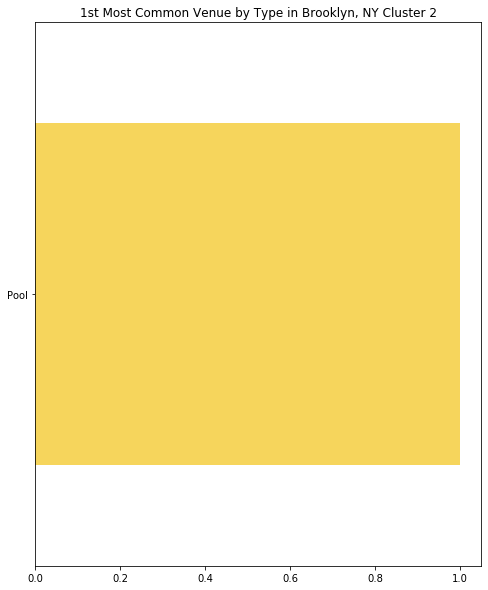

In [42]:
ax2 = clust2_most.plot(kind='barh', figsize=(8, 10), color='#f6d55c', zorder=2, width=0.85)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_title("1st Most Common Venue by Type in Brooklyn, NY Cluster 2")

Text(0.5, 1.0, '1st Most Common Venue by Type in Brooklyn, NY Cluster 3')

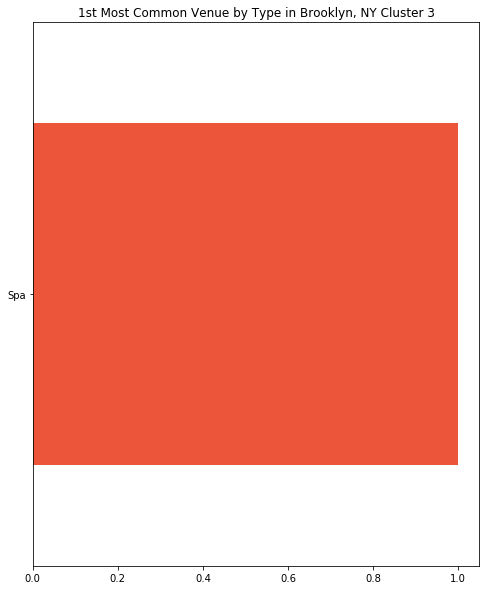

In [43]:
ax3 = clust3_most.plot(kind='barh', figsize=(8, 10), color='#ed553b', zorder=2, width=0.85)
ax3.invert_yaxis()  # labels read top-to-bottom
ax3.set_title("1st Most Common Venue by Type in Brooklyn, NY Cluster 3")

Since the company is thinking about opening a donut shop, let's look a bit deeper into this type of establishment.

In [46]:
donuts = venue_tot[['Neighborhood','Donut Shop','All Venues']]
donuts.sort_values(by=['Donut Shop'], inplace = True)
donuts

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Neighborhood,Donut Shop,All Venues
34,Gerritsen Beach,0,20
24,East Flatbush,0,12
25,East New York,0,15
59,Rugby,0,17
57,Red Hook,0,49
...,...,...,...
3,Bensonhurst,2,33
31,Fort Hamilton,2,69
43,Manhattan Terrace,3,26
14,City Line,3,27


From this table, we see that at most, some neighborhoods (City Line, Homecrest, and Manhattan Terrace) already have 3 donut shops. From a business perspective, it's better to build the shop where there's no similar business to compete against.

Next we will subset the data to only those neighborhoods without a donut shop. The next data shows the top 20 neighborhoods sorted by the number of venues.

In [47]:
no_donuts = donuts[donuts['Donut Shop'] == 0]
no_donuts.sort_values(by=['All Venues'], inplace = True)
no_donuts.tail(20)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Neighborhood,Donut Shop,All Venues
65,Vinegar Hill,0,28
46,Mill Basin,0,32
67,Williamsburg,0,34
64,Sunset Park,0,36
55,Prospect Lefferts Gardens,0,47
57,Red Hook,0,49
22,Dumbo,0,54
53,Park Slope,0,56
32,Fulton Ferry,0,58
30,Fort Greene,0,62


There are several neighborhoods with upwards of 100 venues but no doughnut shops. This list will help the national doughnut chain narrow down their list of selections. Check the final report for the next location to get your doughnuts hot and fresj in Brooklyn!